<a href="https://colab.research.google.com/github/husseindiab/VolatilityPrediction/blob/main/ModelTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is used to train and test the model

In [ ]:
!pip install git+https://github.com/patrick-kidger/torchcde.git #torchcde is package used to implement Neural CDEs

  Cloning https://github.com/patrick-kidger/torchcde.git to /tmp/pip-req-build-g0_esbww
  Running command git clone -q https://github.com/patrick-kidger/torchcde.git /tmp/pip-req-build-g0_esbww
     |████████████████████████████████| 59 kB 6.8 MB/s 
     |████████████████████████████████| 28.5 MB 1.3 MB/s 
     |████████████████████████████████| 193 kB 70.8 MB/s 
  Created wheel for torchcde: filename=torchcde-0.2.3-py3-none-any.whl size=28898 sha256=6e2a52fe64eafb6eb529e56c6d121167f95fe2bb9bf1b910b4312c25c483c761
  Stored in directory: /tmp/pip-ephem-wheel-cache-twppcasi/wheels/57/9e/98/bdb1daad21c5227d3460cdc8cc0dd9e6cb6ef8aeafbcc8505d
Successfully built torchcde
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
alb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
torch.manual_seed(5)
import torchcde
import matplotlib.pyplot as plt
import time
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [ ]:
#this cell contains our loss function
def rmspe(y_true, y_pred):
    return  torch.sqrt(torch.mean(((y_true - y_pred) / y_true)**2))

In [ ]:
#cell is takes in raw time series data and normalizes each feature using different methods

def normalize(X, method = "Z"):
  
  if method == "Z":

    for i in range(X.shape[2]):

      if i == 0:
          X[:,:,i] = torch.from_numpy(MinMaxScaler(copy=False).fit_transform(np.array(X[:,:,i]).reshape(-1,1)).reshape(X.shape[0],  X.shape[1]))

      else:
          X[:,:,i] = (X[:,:,i]-torch.mean(X[:,:,i]))/torch.std(X[:,:,i])
    
  elif method == "Z2":

    for i in range(X.shape[2]):
      
      X[:,:,i] = (X[:,:,i]-torch.mean(X[:,:,i]))/torch.std(X[:,:,i])
  
  elif method == "MinMax":

    for i in range(X.shape[2]):

          X[:,:,i] = torch.from_numpy(MinMaxScaler(copy=False).fit_transform(np.array(X[:,:,i]).reshape(-1,1)).reshape(X.shape[0], X.shape[1]))


  elif method == "MinMax2":

    for i in range(X.shape[0]):

      for j in range(X.shape[2]):

        X[i,:,j] = torch.from_numpy(MinMaxScaler(copy=False).fit_transform(np.array(X[i,:,j]).reshape(-1,1)).reshape(-1))
  
  elif method == "orig":

    for i in range(X.shape[0]):

        X[i,:,0] = torch.from_numpy(MinMaxScaler(copy=False).fit_transform(np.array(X[i,:,0]).reshape(-1,1)).reshape(-1))


    for i in range(1, X.shape[2]):

        X[:,:,i] = torch.from_numpy(MinMaxScaler(copy=False).fit_transform(np.array(X[:,:,i]).reshape(-1,1)).reshape(X.shape[0], X.shape[1]))



  return X

In [ ]:
def get_data(features, X, normalisation = None, method = "Z", LL=False):



  all_feat = ["seconds_in_bucket","vol", "WAP", "BidAskSpread", "log return", "order_count", "size"]

  arrs = []

  for i in range(len(all_feat)):

    if all_feat[i] in features:

      arrs.append(X[:,:,i].reshape(-1,X.shape[1],1))

  if normalisation != None:

    return normalize(torch.cat(arrs, dim=2), method=method)
  
  else:

    return torch.cat(arrs, dim=2)



In [ ]:
#this function is the NN used in the controlled differential equation

class CDEFunc(nn.Module):
  
    def __init__(self, input_channels, layers):
        
        super(CDEFunc, self).__init__()
        self.input_channels = input_channels

        layer_list = []
        
        for i in range(len(layers)-1):
            #layer_list.append(nn.BatchNorm1d(layers[i]))
            layer_list.append(nn.Linear(layers[i],layers[i+1]))
            layer_list.append(nn.ReLU())
            #layer_list.append(nn.Dropout(p=0.4))
        
        layer_list.append(nn.Linear(layers[-1], input_channels*layers[0]))

        self.layers = nn.Sequential(*layer_list)
        

    def forward(self, t, z):

        z = self.layers(z)
        z = z.tanh()

        z = z.view(z.size(0), -1, self.input_channels)

        return z

In [ ]:

# Next, we need to package CDEFunc up into a model that solves the differential equation

class NeuralCDE(nn.Module):
    def __init__(self, input_channels, output_channels, layers=[100], func_layers = [50], prob=0.4, rv = True):
        
        super(NeuralCDE, self).__init__()
      
        n_in = func_layers[0] + sum([nf for ni, nf in emb_szs]) 

        self.func = CDEFunc(input_channels, func_layers) # instantiate NN used in differential equation
        self.initial = torch.nn.Linear(input_channels, func_layers[0])
        self.rv = rv
        
        self.embs = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs]) # instantiate embedding layers

        layer_list = []
        
        for i in layers:
            layer_list.append(nn.BatchNorm1d(n_in))
            layer_list.append(nn.Linear(n_in,i))
            layer_list.append(nn.Dropout(p=prob))
            layer_list.append(nn.ReLU())
            n_in = i
        
        layer_list.append(nn.Linear(layers[-1], output_channels))

        self.layers = nn.Sequential(*layer_list) # create MLP layers to propagate embeds and CDE output 
        

    def forward(self, x, x_cat, RV):

        X = torchcde.LinearInterpolation(x) #construct path from timeseries


        X0 = X.evaluate(X.interval[0])
        z0 = self.initial(X0)
        

        z_T = torchcde.cdeint(X=X, z0=z0, t=X.interval, func=self.func, method ="rk4") #solve CDE
        
        z_T = z_T[:, 1]
        
        embeddings = []

        for i in range(len(self.embs)):
          embeddings.append(self.embs[i](x_cat[:,i]))

        x = torch.cat(embeddings, 1) #output of embedding layer
        
        x = torch.cat([z_T,x], dim=1) #concatenate CDE output with embedding layer

        pred = self.layers(x) #propagate concat through MLP

        if self.rv:
          return RV*pred #multiply pred by vol of prev 10 min window
        else:
          return pred

    
    def backward(self, loss, optimizer): #backpropagation
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
def split_data(num=9):

  a = np.linspace(0,400000, num=num, endpoint=True)

  splits = [(int(a[i]), int(a[i+1])) for i in range(a.shape[0]-1)]
  splits.append((400000,-1))

  data = []

  for start, end in splits:

    data.append((X_train[start:end], X_cat_train[start:end], RV_train[start:end], Y_train[start:end]))

  return data

In [ ]:
feat = ["seconds_in_bucket","vol", "WAP", "BidAskSpread", "log return", "order_count", "size"] # features used in training data

In [ ]:
X = get_data(feat, torch.load("/content/drive/MyDrive/600.pt"), normalisation=True, method="orig").float()

In [ ]:
X.shape #(batch, series length, num channels)

torch.Size([428932, 600, 7])

In [ ]:
X_cat = torch.load("/content/drive/MyDrive/X_cat.pt").long() #(stock_id, time_id) data to be used in embedding layers
RV = torch.load("/content/drive/MyDrive/RV.pt").float()*1000 #volatility of previous period used to forecast next period
Y = torch.load("/content/drive/MyDrive/Y.pt").float()*1000 #target volatilities

In [ ]:
#shuffling data
perm = torch.randperm(X.shape[0])
X = X[perm]
X_cat = X_cat[perm]
RV = RV[perm]
Y = Y[perm]

In [ ]:
#separating data into test and train sets  - test set not to be trained upon

test_size = 1000
X_train = X[:-test_size].to("cuda")
X_cat_train = X_cat[:-test_size].to("cuda")
Y_train = Y[:-test_size].to("cuda")
RV_train = RV[:-test_size].to("cuda")


In [ ]:
#split training set into batches for memory purposes
data = split_data()

In [ ]:
X_test = X[-test_size:].to("cuda")
X_cat_test = X_cat[-test_size:].to("cuda")
Y_test = Y[-test_size:].to("cuda")
RV_test = RV[-test_size:].to("cuda")

In [ ]:
num_stocks = max(X_cat[:,0]).item()+1
num_times = max(X_cat[:,1]).item()+1
num_feat = X_train.shape[-1]

In [ ]:
# specific hyperparamters of model

emb_szs = [(num_stocks, 50), (num_times, 50)] #embedding layer sizes
func_layers = [50]  #layers of the CDEFunc
layers = [75]  #MLP layers atop of neuralCDE and embedding layers
prob = 0.6  #dropout probability for regularisation
lr = 0.001  #learning rate
Rv = True  #specifying to the model that we do want to consider volatility of previous 10-minute window

In [ ]:
# MEMORY PURPOSES

try:

  del model
  del optimizer
  del y_pred
  del y_val
  del loss
  del val_loss
  torch.cuda.empty_cache()

except:
  
  print("no model to delete")


no model to delete


In [ ]:
model = NeuralCDE(input_channels = num_feat, func_layers = func_layers, output_channels=1, layers=layers, prob=prob, rv=Rv).cuda()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Epoch 20: Train Loss = 0.34247956342167324
Epoch 40: Train Loss = 0.2939646542072296
Epoch 60: Train Loss = 0.25447365641593933
Epoch 80: Train Loss = 0.23625223669740888
Epoch 100: Train Loss = 0.22790108952257368
Epoch 120: Train Loss = 0.2235211713446511
Epoch 140: Train Loss = 0.22141388224230873
Epoch 160: Train Loss = 0.2191194345553716
Epoch 180: Train Loss = 0.2177328715721766
Epoch 200: Train Loss = 0.21766268544726902
Epoch 220: Train Loss = 0.21691809594631195
Epoch 240: Train Loss = 0.2173769474029541
Epoch 260: Train Loss = 0.2159116566181183
Epoch 280: Train Loss = 0.21608909467856088
Epoch 300: Train Loss = 0.21546345618036059
Epoch 320: Train Loss = 0.21541942656040192
Epoch 340: Train Loss = 0.21469594207074907
Epoch 360: Train Loss = 0.21527194645669726
Epoch 380: Train Loss = 0.21534592906634012
Epoch 400: Train Loss = 0.2153107225894928
Epoch 420: Train Loss = 0.21504247354136574
Epoch 440: Train Loss = 0.21461854378382364
Epoch 460: Train Loss = 0.21471002366807726

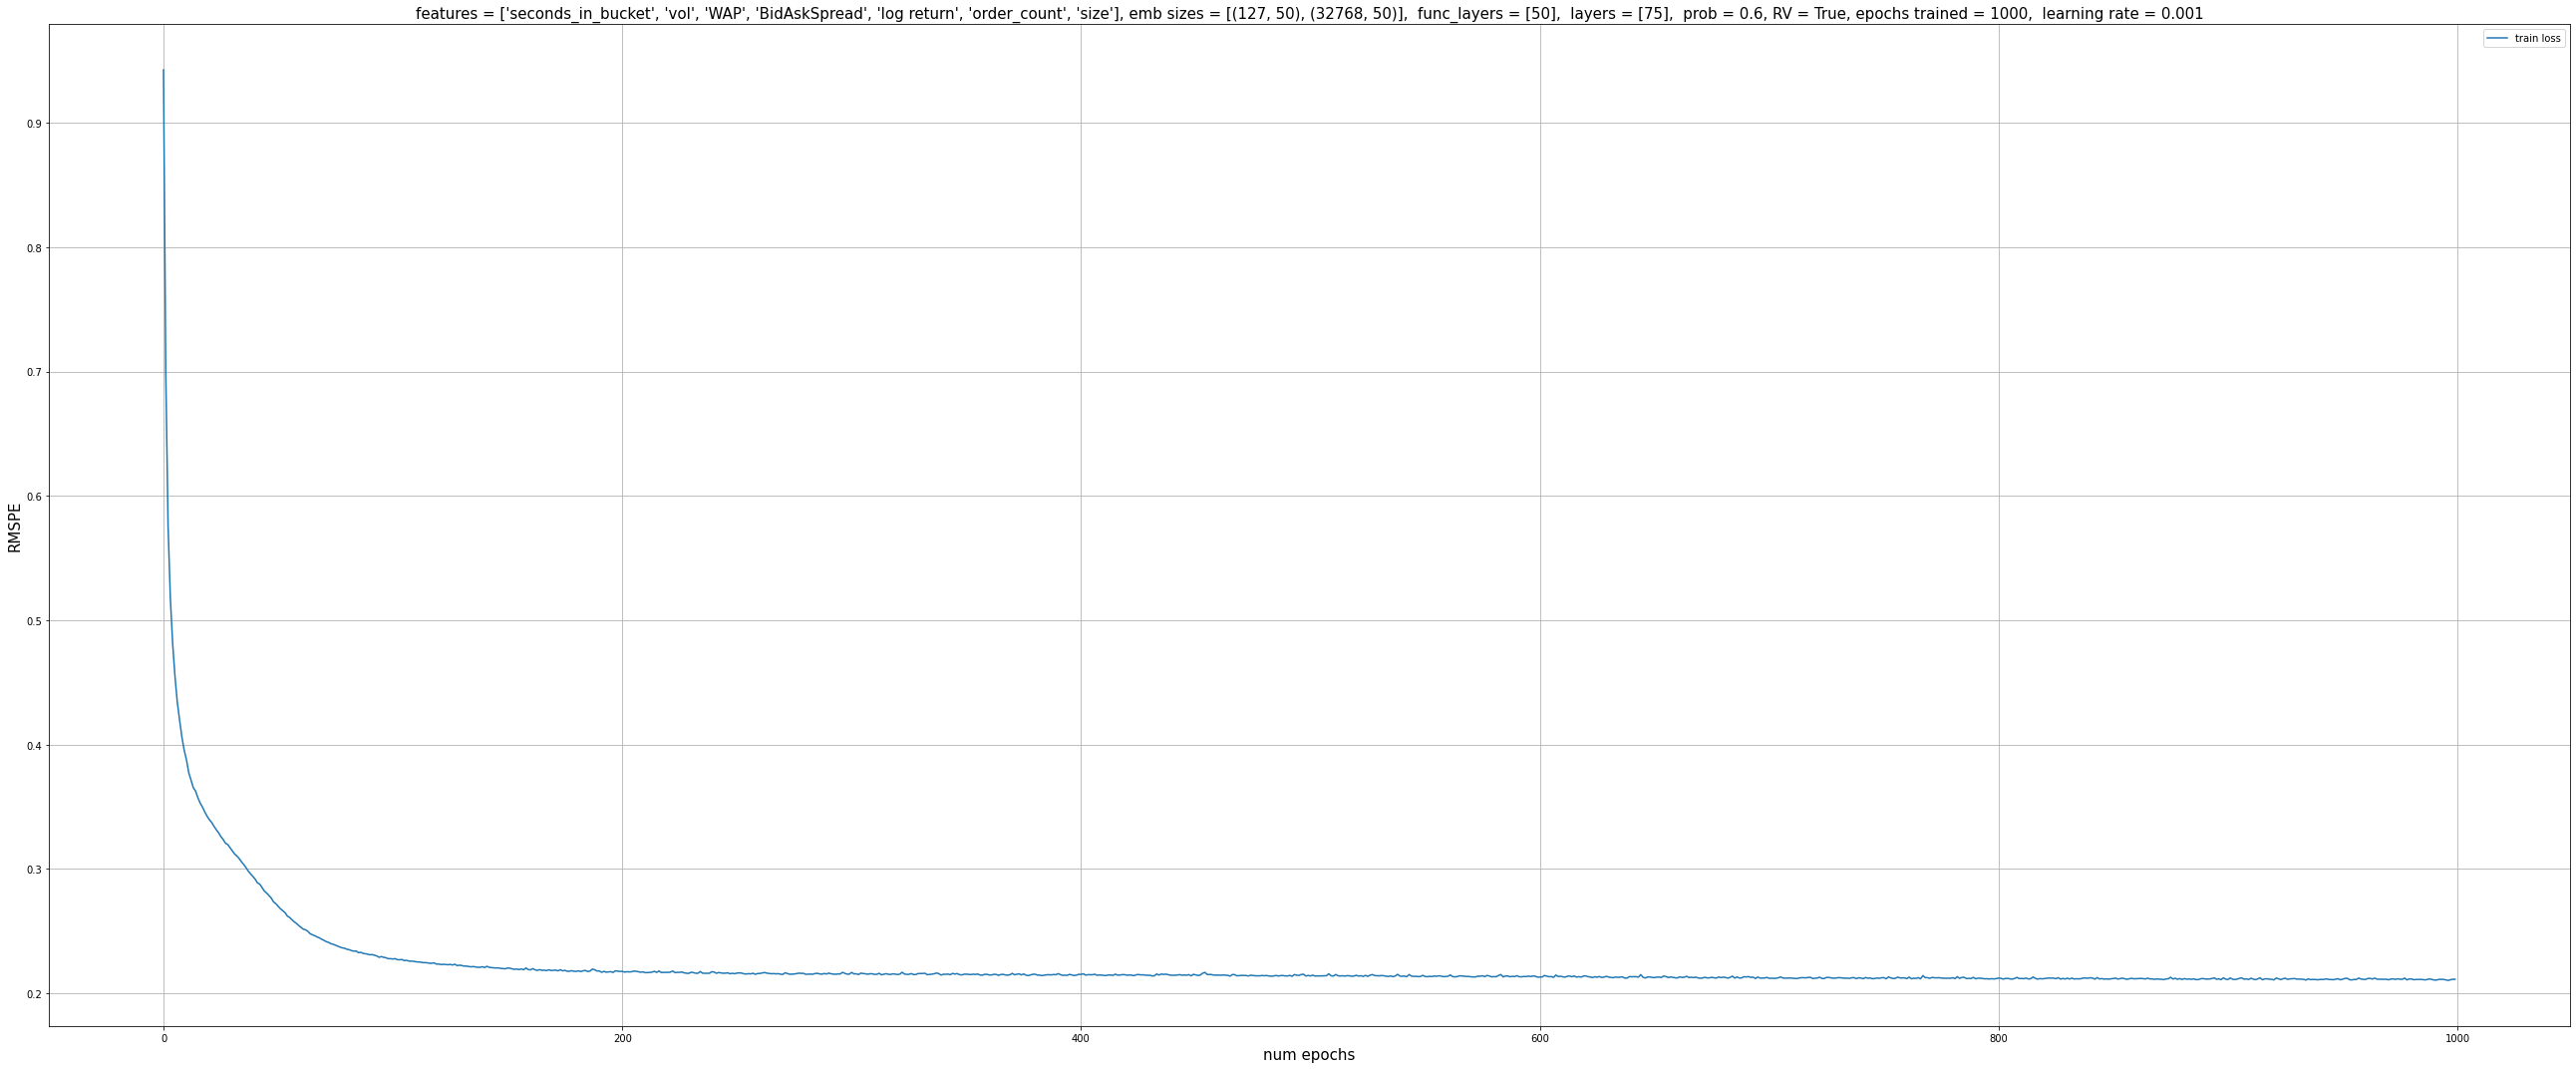

In [73]:
#training loop

epochs = 1000
train_losses = []
test_losses = []

for i in range(epochs):

        #print("---------------------- Epoch {} -----------------------".format(i+1))
        #print("")

        #start = time.time()
        
        tot = 0

        for x, x_cat, rv, y in data:

          y_pred = model.forward(x, x_cat, rv)

          loss = rmspe(y, y_pred)

          tot+=loss.item()

          model.backward(loss, optimizer)

        train_losses.append(tot/len(data))
        '''
    
        y_pred = model.forward(X_train, X_cat_train, RV_train)

        loss = rmspe(Y_train, y_pred)

        train_losses.append(loss.item())

        model.backward(loss, optimizer)
        '''
        
        if (i+1)%20==0 and i!=0:

          print("Epoch {}: Train Loss = {}".format(i+1, train_losses[i]))
            
        if i+1==epochs:       
                      
              plt.figure(figsize=(36,15))
              plt.title(f"features = {feat}, emb sizes = {emb_szs},  func_layers = {func_layers},  layers = {layers},  prob = {prob}, RV = {Rv}, epochs trained = {i+1},  learning rate = {lr}", fontsize=15)
              plt.plot(range(i+1), train_losses)
              #plt.plot(range(i+1), test_losses)
              plt.xlabel("num epochs", fontsize=15)
              plt.ylabel("RMSPE", fontsize=15)
              plt.grid(True)
              plt.legend(['train loss'])#, 'test loss'])
              plt.tight_layout()
              plt.show()


 

In [74]:
# now we evaluate how the model does on the test set: we turn off all dropout and batch norm layers and use the full network

model.eval()

with torch.no_grad():

    y_val = model.forward(X_test, X_cat_test, RV_test)
              
    val_loss = rmspe(Y_test, y_val)
              
    print("Final Test Loss = {}".format(val_loss.item()))

Final Test Loss = 0.20205745100975037
